# CSC420 Project - Road Computer Vision

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

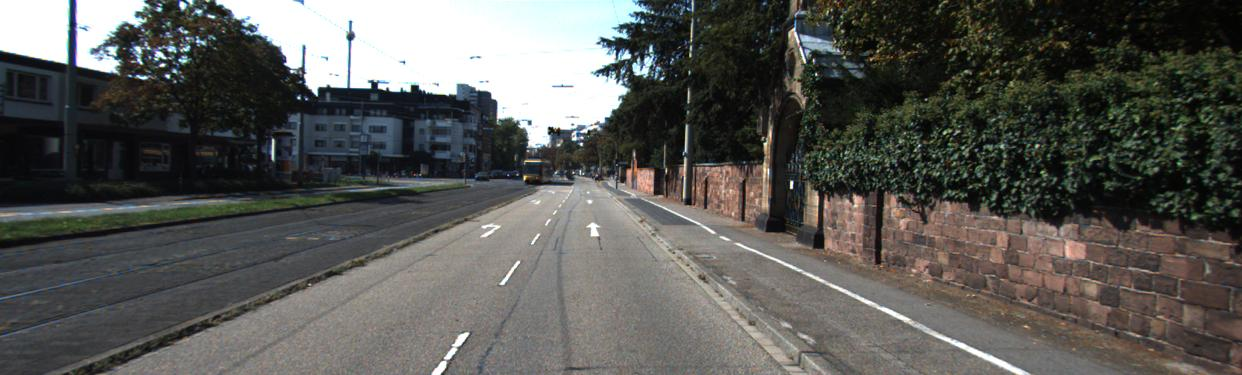

In [ ]:
imageLeft = cv2.imread('drive/MyDrive/project2/train/image_left/um_000001.jpg')
imageRight = cv2.imread('drive/MyDrive/project2/train/image_right/um_000001.jpg')
cv2_imshow(imageLeft)

## Part 1 Compute Disparity Between Two Images


In [ ]:
def computeDisparity(imageLeft, imageRight, numDisparities=128, blockSize=5):
    disparity = np.zeros(imageLeft.shape)

    length, width = imageLeft.shape

    zero_padding_shape = length + blockSize - 1, width + blockSize - 1

    temp = blockSize // 2

    left_padder = np.zeros(zero_padding_shape)
    left_padder[temp:(length + temp), temp:(width + temp)] = imageLeft

    right_padder = np.zeros(zero_padding_shape)
    right_padder[temp:(length + temp), temp:(width + temp)] = imageRight

    # vectorized patches for right image in the form of a matrix
    vectorizedRight = np.zeros((length, width, blockSize**2))

    for i in range(length):
        for j in range(width):
            patchLeft = left_padder[i:(i + blockSize), j:(j + blockSize)].reshape(-1)
            patchRight = right_padder[i:(i + blockSize), j:(j + blockSize)].reshape(-1)
            
            vectorizedRight[i, j, :] = patchRight

            # we want absolute intensity difference
            one = np.copy(vectorizedRight[i, max(0, j - numDisparities):j + 1, :])
            result = np.sum(np.abs(one - patchLeft), axis=1)

            # get best match
            result = np.flip(result, 0)
            disparity[i, j] = np.argmin(result)

    return disparity

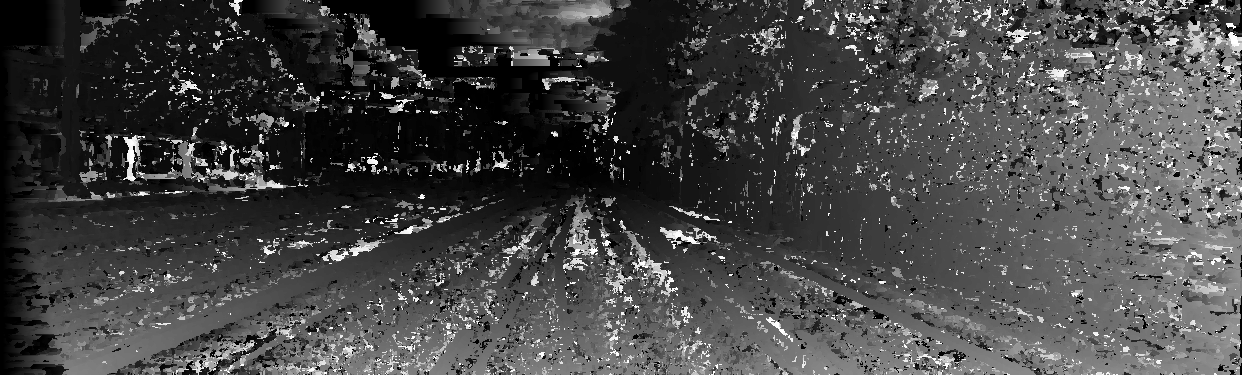

In [ ]:
disparity = computeDisparity(cv2.cvtColor(imageLeft, cv2.COLOR_BGR2GRAY), cv2.cvtColor(imageRight, cv2.COLOR_BGR2GRAY))
cv2_imshow(cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX))

## Part 2 Compute Depth Between Two Images and 3D coordinates

In [ ]:
def computeDepth(disparity, focalLength=721.5, baseline=0.54):
    depth = np.divide(focalLength * baseline, disparity, out=np.ones(disparity.shape) * 0.01, where=disparity!= 0)
    return depth

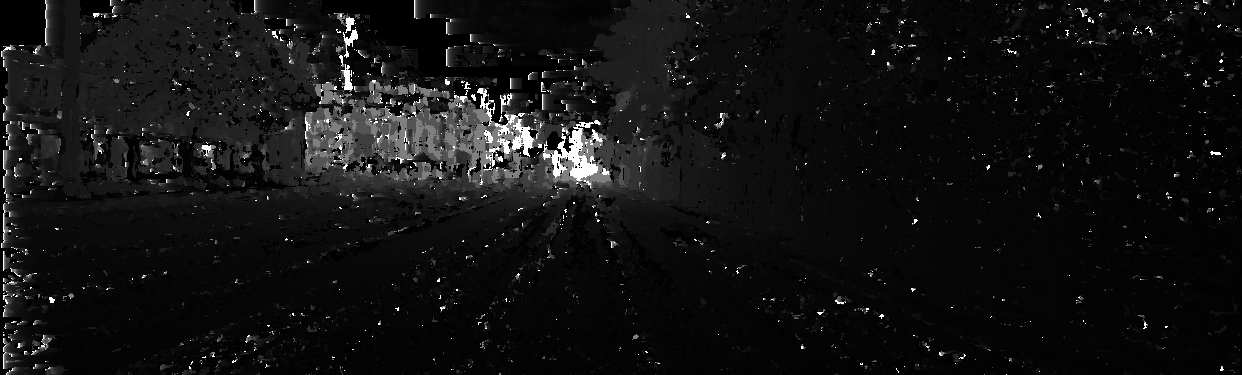

In [ ]:
depth = computeDepth(disparity)
cv2_imshow(cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX))

In [ ]:
def coord3d(depth, focalLength=721.5):
    x, y, z = [], [], []
    for i in range(depth.shape[0]):
        for j in range(depth.shape[1]):
            x.append(-depth[i, j] * (i - depth.shape[0]//2) / focalLength)
            y.append(depth[i, j] * (j - depth.shape[1]//2) / focalLength)
            z.append(depth[i, j])
    
    return np.array([x, y, z])

In [ ]:
coord = coord3d(depth)

## Part 3 Road Segmentation

## Part 4 Road Plane RANSAC

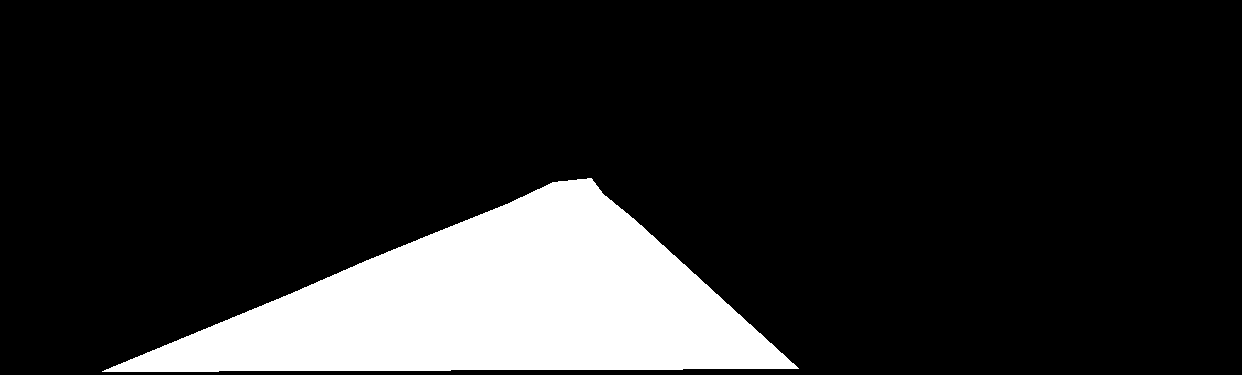

In [ ]:
imageLeftRoadPixels = cv2.imread('drive/MyDrive/project2/train/gt_image_left/um_road_000001.png', 0)
roadFilter = (imageLeftRoadPixels > 0).reshape(-1)
cv2_imshow(imageLeftRoadPixels)

In [ ]:
def roadRANSAC(coord, iterations, threshold):
    N = coord.shape[1]
    best_inliers = 0
    best_plane = 0, 0, 0, 0
    for i in range(iterations):
        # Choose 3 random points
        ix = np.random.choice(range(N), size=3, replace=False)
        p1, p2, p3 = coord[:, ix[0]], coord[:, ix[1]], coord[:, ix[2]]
        # Plane calculation
        v1 = p3 - p1
        v2 = p2 - p1
        cp = np.cross(v1, v2)
        # Plane values
        a, b, c = cp
        d = np.dot(cp, p3)
        # Inlier counts
        dist = np.abs(a*coord[0] + b*coord[1] + c*coord[2] + d) / np.sqrt(a**2 + b**2 + c**2)
        inliers = sum(dist < threshold)
        # Save plane if better than previous
        if best_inliers < inliers:
            best_inliers = inliers
            best_plane = a, b, c, d

    return best_plane, best_inliers / N

In [ ]:
roadPlane, acc = roadRANSAC(coord[:,roadFilter], 1000, 0.5)
print(roadPlane, acc)

(-188.27387532467532, 1.9305350649350643, -26.084222577422576, -33.069598597402596) 0.6728836839441914


In [ ]:
a, b, c, d = roadPlane

## Part 5 Point Cloud

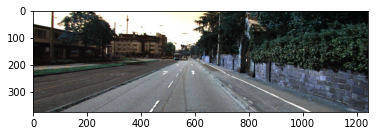

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(imageLeft)

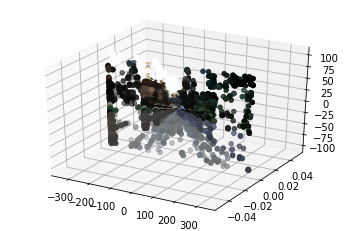

In [ ]:
colors = imageLeft.reshape(-1, 3) / 255
colors_list = []
for i in range(colors.shape[0]):   
    colors_list.append((colors[i, 0], colors[i, 1], colors[i, 2]))

ax = plt.axes(projection='3d')
ax.scatter3D(coord[1], 0, coord[0], c=colors_list);

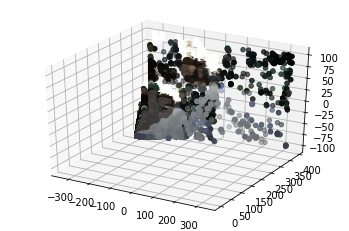

In [ ]:
ax = plt.axes(projection='3d')
ax.scatter3D(coord[1], coord[2], coord[0], c=colors_list);

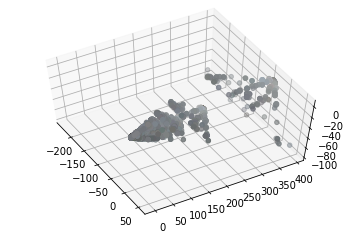

In [ ]:
colors_list_filtered = []
for i in range(len(roadFilter)):
    if roadFilter[i]:
        colors_list_filtered.append((colors[i, 0], colors[i, 1], colors[i, 2]))

ax = plt.axes(projection='3d')
ax.scatter3D(coord[1, roadFilter], coord[2, roadFilter], coord[0, roadFilter], c=colors_list_filtered)
ax.view_init(60, -30)

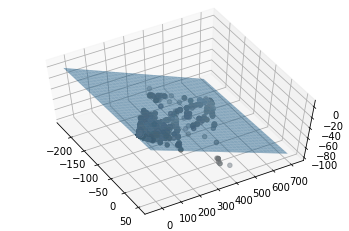

In [ ]:
plt3d = plt.figure().gca(projection='3d')
x, y = np.meshgrid(range(int(np.min(coord[0, roadFilter])), int(np.max(coord[0, roadFilter]))), 
                     range(int(np.min(coord[1, roadFilter])), int(np.max(coord[1, roadFilter]))))
z = (d - a * x - b * y) / c
plt3d.plot_surface(y, z, x, alpha=0.5)

ax = plt.gca()
ax.scatter3D(coord[1, roadFilter], coord[2, roadFilter], coord[0, roadFilter], c=colors_list_filtered);
ax.view_init(60, -30)

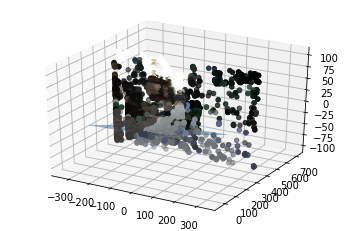

In [ ]:
plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(y, z, x, alpha=0.5)

ax = plt.gca()
ax.scatter3D(coord[1], coord[2], coord[0], c=colors_list);

## Part 6 Car Detection

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


In [ ]:
import detectron2

# import common libraries
import os, json, random

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

## Part 7 Viewpoint Classifier

In [ ]:
import scipy.io
from os import listdir
from skimage import feature

train_features = []
train_labels = []

for im_f in listdir('drive/MyDrive/project2/train_angle/image/'):
    # Read image
    im = cv2.imread('drive/MyDrive/project2/train_angle/image/' + im_f)
    # Get annotations corresponding to image
    label_f = im_f[0:-3] + "mat"
    mat = scipy.io.loadmat('drive/MyDrive/project2/train_angle/labels/' + label_f)
    annotation = mat['annotation']
    # Extract annotations
    class_obj = annotation[0, 0]['class']
    boxes = annotation[0, 0]['bboxes']
    truncated = annotation[0, 0]['truncated']
    occlusion = annotation[0, 0]['occlusion']
    orient = annotation[0, 0]['orient']
    N = boxes.shape[0]
    # Iterate over objects and extract their features and their viewpoints
    for obj in range(N):
        # Skip if not a car
        if class_obj[:, obj][0] != 'Car':
            continue
        # Skip if not good data
        if truncated[:, obj][0] > 0.3 or occlusion[:, obj][0] > 2:
            continue
        # Feature
        x, y, l, w = boxes[obj]
        im_car = cv2.resize(im[int(y):int(y+w), int(x):int(x+l)], (400, 200))
        im_car = feature.canny(cv2.cvtColor(im_car, cv2.COLOR_BGR2GRAY))
        train_features.append(im_car)
        # Label
        label = round(orient[obj][0] / 30) % 12
        train_labels.append(label)

train_features = np.array(train_features).reshape(-1, 80000)
train_labels = np.array(train_labels)

In [ ]:
from os import listdir

test_features = []

for im_f in listdir('drive/MyDrive/project2/test/image_left/'):
  # Read image
  im = cv2.imread('drive/MyDrive/project2/test/image_left/' + im_f)
  # Detect objects
  outputs = predictor(im)
  # Extract detected objects
  instances = outputs["instances"]
  box = iter(instances.pred_boxes[instances.pred_classes == 2])
  N = instances.pred_classes[instances.pred_classes == 2].shape[0]
  # Iterate over objects and extract their features
  for obj in range(N):
    x0, y0, x1, y1 = next(box)
    im_car = cv2.resize(im[int(y0):int(y1), int(x0):int(x1)], (400, 200))
    im_car = feature.canny(cv2.cvtColor(im_car, cv2.COLOR_BGR2GRAY))
    test_features.append(im_car)

test_features = np.array(test_features).reshape(-1, 80000)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Train Gaussian Naive Bayes Classifier with edges as input and viewpoint class as output
clf = GaussianNB()
clf.fit(train_features, train_labels)

GaussianNB()

In [ ]:
pred_train_labels = clf.predict(train_features)
pred_test_labels = clf.predict(test_features)
train_acc = np.mean(pred_train_labels == train_labels)
print(train_acc)

0.9715489989462592


# Part 8 Test Image

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


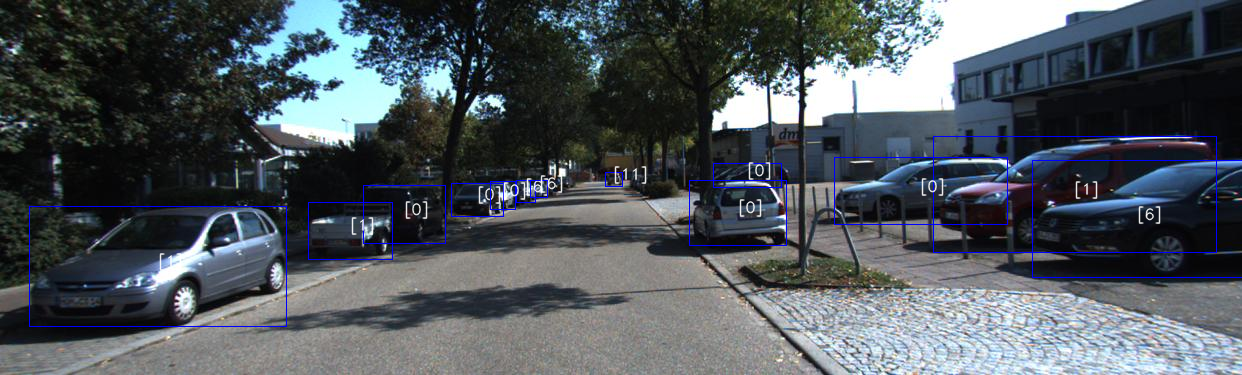

In [ ]:
imageTest = cv2.imread('drive/MyDrive/project2/test/image_left/uu_000003.jpg')
# Detect objects
outputs = predictor(imageTest)
# Extract detected objects
instances = outputs["instances"]
box = iter(instances.pred_boxes[instances.pred_classes == 2])
N = instances.pred_classes[instances.pred_classes == 2].shape[0]
# Iterate over objects and box them on image
for obj in range(N):
  x0, y0, x1, y1 = next(box)
  cv2.rectangle(imageTest, (int(x0), int(y0)), (int(x1), int(y1)), (255, 0, 0), 1)

  im_car = cv2.resize(im[int(y0):int(y1), int(x0):int(x1)], (400, 200))
  im_car = feature.canny(cv2.cvtColor(im_car, cv2.COLOR_BGR2GRAY))
  view = clf.predict(im_car.reshape(-1, 80000))
  cv2.putText(imageTest, str(view), (int((x0+x1)/2), int((y0+y1)/2)), 
              cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1,cv2.LINE_AA)
cv2_imshow(imageTest)

# Part 9 3D Bounding Box